In [ ]:
!pip install transformers
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/My Drive/AN2DL/Exercise_7

/gdrive/My Drive/PhD/Courses/HUMAN-COMPUTER INTERACTION FOR AI/Bot Lennon


In [ ]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup, set_seed

import nltk
nltk.download('punkt')

In [ ]:
df = pd.read_csv('Eminem.csv', encoding= 'unicode_escape')  
df.tail()

,artist,title,Lyrics
95,Eminem,Bad Husband,"We never saw from each other's sides, or eye t..."
96,Eminem,Going Through Changes,I'm going through changes\nI'm going through c...
97,Eminem,Cinderella Man,"Yeah, you know, technically\nI'm not even real..."
98,Eminem,We Made You,"Guess who? D'you miss me?\nJessica Simpson, si..."
99,Eminem,Yah Yah,"Yah, yah, yah, yah, yah (People)\nYah, yah, ya..."


In [ ]:
texts = df.Lyrics.dropna().copy()
texts[86]

'Down, down, down\nDown, down, down\nDown, down, down\nDown, okay\nGuess who\'s back, back again\nShady\'s back, tell a friend\nNow everyone report to the dance floor\nTo the dance floor, to the dance floor\nNow everyone report to the dance floor\nAlright, stop, pajama time\n\nCome here, little kiddies, on my lap\nGuess who\'s back with a brand new rap?\nAnd I don\'t mean "rap" as in a new case\nOf child molestation accusations\nAh-ah-ah-ah-ah, no worries\nPapa\'s got a brand new bag of toys\nWhat else could I possibly do to make noise?\nI done touched on everything but little boys\nAnd that\'s not a stab at Michael\nThat\'s just a metaphor, I\'m just psycho\nI go a little bit crazy sometimes\nI get a little bit out of control with my rhymes\nGood God, dip, do a little slide\nBend down, touch your toes, and just glide\nUp the center of the dance floor\nLike TP for my bung-hole\nAnd it\'s cool if you let one go\nNobody\'s gonna know, who\'d hear it?\nGive a little poot-poot, it\'s okay\

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


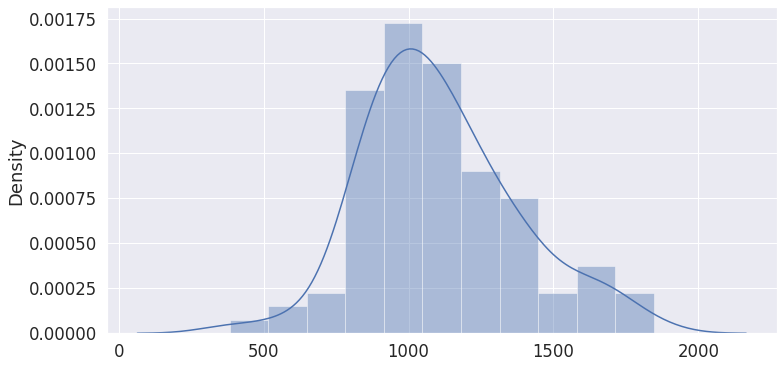

In [ ]:
doc_lengths = []

for t in texts:
    # get rough token count distribution
    tokens = nltk.word_tokenize(t)
    doc_lengths.append(len(tokens))
doc_lengths = np.array(doc_lengths)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
sns.distplot(doc_lengths)

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [ ]:
batch_size = 2

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
dataset = GPT2Dataset(texts, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   95 training samples
    5 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42
set_seed = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 15
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        # if step % sample_every == 0 and not step == 0:

        #     elapsed = format_time(time.time() - t0)
        #     print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

        #     model.eval()

        #     sample_outputs = model.generate(
        #                             bos_token_id=random.randint(1,30000),
        #                             do_sample=True,   
        #                             top_k=50, 
        #                             max_length = 200,
        #                             top_p=0.95, 
        #                             num_return_sequences=1
        #                         )
        #     for i, sample_output in enumerate(sample_outputs):
        #           print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
        #     model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 15 ========
Training...

  Average training loss: 17.72
  Training epoch took: 0:00:49

Running Validation...
  Validation Loss: 5.32
  Validation took: 0:00:01

======== Epoch 2 / 15 ========
Training...

  Average training loss: 4.46
  Training epoch took: 0:00:49

Running Validation...
  Validation Loss: 4.05
  Validation took: 0:00:01

======== Epoch 3 / 15 ========
Training...

  Average training loss: 3.54
  Training epoch took: 0:00:48

Running Validation...
  Validation Loss: 3.77
  Validation took: 0:00:01

======== Epoch 4 / 15 ========
Training...

  Average training loss: 3.23
  Training epoch took: 0:00:48

Running Validation...
  Validation Loss: 3.73
  Validation took: 0:00:01

======== Epoch 5 / 15 ========
Training...

  Average training loss: 3.02
  Training epoch took: 0:00:48

Running Validation...
  Validation Loss: 3.76
  Validation took: 0:00:01

======== Epoch 6 / 15 ========
Training...

  Average training loss: 2.86
  Training epoch took: 0

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,17.72,5.32,0:00:49,0:00:01
2,4.46,4.05,0:00:49,0:00:01
3,3.54,3.77,0:00:48,0:00:01
4,3.23,3.73,0:00:48,0:00:01
5,3.02,3.76,0:00:48,0:00:01
6,2.86,3.78,0:00:49,0:00:01
7,2.71,3.82,0:00:49,0:00:01
8,2.57,3.89,0:00:49,0:00:01
9,2.44,3.95,0:00:49,0:00:01


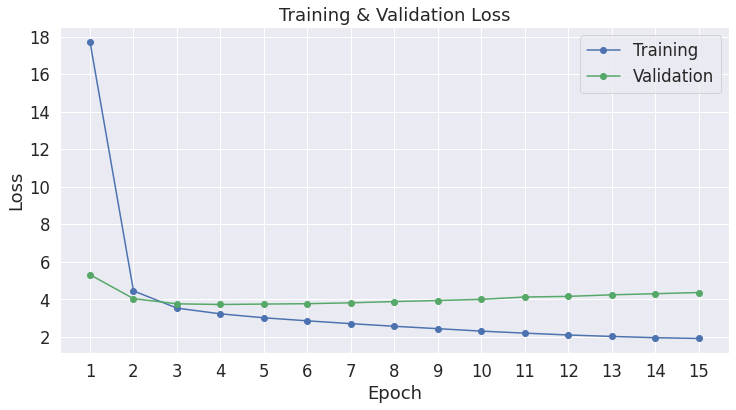

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(epochs)+1)

plt.show()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/Eminem/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


### Load models and have fun

In [ ]:
output_dir = './model_save/Eminem/'
imported_tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
imported_model = GPT2LMHeadModel.from_pretrained(output_dir)

imported_model.eval()
imported_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [ ]:
prompt = "<|startoftext|>The climate warming"

generated = torch.tensor(imported_tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = imported_model.generate(
    generated,
    do_sample=True,
    top_k=40,
    top_p=0.95,
    repetition_penalty=1.05,
    min_length = 30,
    max_length = 300,
    num_return_sequences=1
    )

print(imported_tokenizer.decode(sample_outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The climate warming trend
We're leaving behind the legacy of that disastrous and on-the-record a lot to talk about
The legacy I carry over from my time as Vice President:
So many lives we touched, so much pain that tore us all apart
We may seem like a frickin' wound that won't heal
Even if we stay strapped forever to this Earth's sole rock
With no other choice than make our own way home
In this age when even the most honorable men can achieve great things
Only God knows how long it'll be until he forgives his father for what he did not do or say to him
He made the wise move
It hasn't been his life that changed; he's still here, you see
But this world is at an end now. in effect
I'm torn; but lucky enough to have had some time to think before taking matters into account
Ayo takin' shots at 'em both ways
The way they laugh, there ain't no such thing then"
Snoop Dogg, please! Do me one favor! You better prepare yourself, gentlemen!" "Shoot, jump off point A while back," I barked out as a 